In [8]:
from glob import glob
import os
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib
import re

import sys
home=os.path.expanduser("~")
sys.path.append(os.path.join(home, 'station2grid'))

from tools import plotMap, CommonObj
%matplotlib inline

In [9]:
info = CommonObj().epa_station_info
info.head()

,SiteName,SiteEngName,area,lat,lon,lat_round,lon_round,row,col
0,大霸尖山,Dabajianshan,mountain,24.461111,121.249722,24.46,121.25,88,125
1,牧山,Mushan,mountain,23.864722,121.152222,23.86,121.15,148,115
2,玉山,Yushan,mountain,23.470556,120.948889,23.47,120.95,187,95
3,北大武山,Beidawushan,mountain,22.629167,120.751944,22.63,120.75,271,75
4,陽明,Yangming,city,25.182722,121.529583,25.18,121.53,16,153


# read

In [10]:
info = CommonObj().epa_station_info
info.head(1)


,SiteName,SiteEngName,area,lat,lon,lat_round,lon_round,row,col
0,大霸尖山,Dabajianshan,mountain,24.461111,121.249722,24.46,121.25,88,125


In [28]:
feature_list = [
    'pm25'
#     'pm25_pm10',
#     'pm25_PM10'
#     'pm25_PM10_NO2_SO2_O3',
#     'pm25_AMBTEMP_RH_RAINFALL_WINDCOS_WINDSIN',
#     'pm25_AMBTEMP_RH_RAINFALL_WINDCOS_WINDSIN_PM10_NO2_SO2_O3',
]

# station_list = info.SiteEngName.values
# station_list = ['Dabajianshan','Mushan','Yushan','Beidawushan',
#                 'Guting','Banqiao','Zhongli','Xitun','Tainan','Fengshan',
#                 'Yilan','Hualien','Taitung','Hengchun'] 

station_list = ['Tainan']

In [34]:
def f(path):
    #print(path)
    
    model_name = re.search('model_name-(.+?)--',path).group(1)
    
    
    if model_name == 'station2gridSD' : 
        domain = re.search('domain-(.+?)--',path).group(1)
        val_stations = re.search('val_stations-(.+?)--',path).group(1)
        features = re.search('features-(.+?)--',path).group(1)
        if val_stations in station_list:
            if features in feature_list:
                if domain in ['sat']:
                    #print(path)
                    return True
    
    
    
    # 's2gsd_minmax','s2gsd_standard'
#     if model_name in ['s2gsd_minmax']: return True
#     else: return False
    
#     if model_name in ['s2gsd_minmax','s2gmd_minmax']: 
#         features = re.search('features-(.+?)--',path).group(1)
#         if features in feature_list: return True
    
        
#     if model_name=='knn': 
#         k = re.search('k-(.+?)--',path).group(1)
#         weightKNN = re.search('weightKNN-(.+?)--',path).group(1)
#         if (k,weightKNN)==('4','distance'): return True
        
#     if model_name=='krg': return True 
        
#     if model_name==['gan','gan_grid']: return False
    
#     if model_name=='station2gridMD': return True
    
    return False
    
paths = glob(os.path.join('..','results','*csv'))
paths = [path for path in paths if f(path)==True]
paths = sorted(paths)

len(paths)
paths


['../results/model_name-station2gridSD--features-pm25--val_stations-Tainan--domain-sat--k-3--weightKNN-distance--ae_type-code_length-2288--dnn_type-a1---.csv',
 '../results/model_name-station2gridSD--features-pm25--val_stations-Tainan--domain-sat--k-3--weightKNN-distance--ae_type-code_length-3432--dnn_type-a1---.csv',
 '../results/model_name-station2gridSD--features-pm25--val_stations-Tainan--domain-sat--k-3--weightKNN-distance--ae_type-code_length-4576--dnn_type-a1---.csv',
 '../results/model_name-station2gridSD--features-pm25--val_stations-Tainan--domain-sat--k-3--weightKNN-distance--ae_type-code_length-5720--dnn_type-a1---.csv',
 '../results/model_name-station2gridSD--features-pm25--val_stations-Tainan--domain-sat--k-3--weightKNN-distance--ae_type-code_length-6864--dnn_type-a1---.csv']

In [35]:
dfs = [pd.read_csv(path) for path in paths]

result = pd.concat(dfs, axis=0)
result.head()

,group,station,dt,predict,real
0,model_name-station2gridSD--features-pm25--val_...,Tainan,2019-01-01 00:00:00,10.314794,17.0
1,model_name-station2gridSD--features-pm25--val_...,Tainan,2019-01-01 01:00:00,13.008389,20.0
2,model_name-station2gridSD--features-pm25--val_...,Tainan,2019-01-01 02:00:00,13.335154,14.0
3,model_name-station2gridSD--features-pm25--val_...,Tainan,2019-01-01 03:00:00,13.819669,15.0
4,model_name-station2gridSD--features-pm25--val_...,Tainan,2019-01-01 04:00:00,10.663378,10.0


In [36]:
result.station.unique()


array(['Tainan'], dtype=object)

# mse

In [37]:
# mean_squared_error

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def mape(y_true, y_pred): 
    eps = 1e-16
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true+eps))) * 100

In [38]:
by=['group', 'station'] #keys+['method','station']
df_mse=result.groupby(by).apply(lambda row: mean_squared_error(row.real, row.predict)).reset_index(name='value')
print(df_mse.shape)
df_mse.head()


(5, 3)


,group,station,value
0,model_name-station2gridSD--features-pm25--val_...,Tainan,42.307713
1,model_name-station2gridSD--features-pm25--val_...,Tainan,45.543325
2,model_name-station2gridSD--features-pm25--val_...,Tainan,37.699236
3,model_name-station2gridSD--features-pm25--val_...,Tainan,36.372142
4,model_name-station2gridSD--features-pm25--val_...,Tainan,38.557790


In [39]:
site2area=dict(zip(info.SiteEngName,info.area,))
df_mse['area']=df_mse.station.apply(lambda x: site2area[x])
# df_mse

In [42]:
def parse(path, key='dnn_type'):
    match = re.search('(--|^)%s-(.+?)(--|$)'%(key), path)
    value = match.group(2) if match != None else '' ###
    return value
    
mehtod_keywords=['model_name','domain','ae_type'] # ['model_name','domain','k','weightKNN','composite_type','features']
for key in mehtod_keywords:
    df_mse[key] = df_mse.group.apply(lambda x: parse(x, key=key))
    
df_mse['method'] = df_mse.apply(
    lambda row: '-'.join([row[key] for key in mehtod_keywords]),axis=1)


([<matplotlib.axis.XTick at 0x7f377522ffd0>,
 <a list of 5 Text xticklabel objects>)

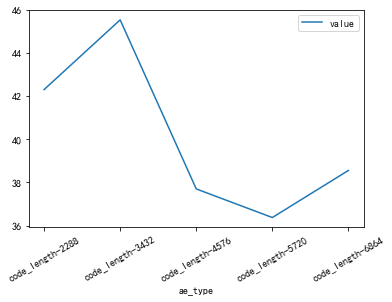

In [50]:
df_mse[['model_name','domain','ae_type','station','value',]].plot(x='ae_type',y='value')
plt.xticks(df_mse.index, df_mse.ae_type, rotation=30)

In [239]:
mountains = ['Dabajianshan','Mushan','Yushan','Beidawushan',]
df_mse.loc[(df_mse.model_name=='s2gmd_minmax')&(~df_mse.station.isin(mountains)),'value'] = np.random.normal(34, 13, 10)
df_mse.loc[(df_mse.model_name=='s2gmd_minmax')&(df_mse.station.isin(mountains)),'value'] = np.random.normal(500, 200, 4)

# df_mse.loc[df_mse.model_name=='s2gmd_minmax','value'] = np.random.normal(34, 13, 14)



In [240]:
# df_mse

In [241]:
# df_mse['norm'] = df_mse['model_name'].apply(lambda x: x.split('_')[0])
# df_mse['repeat'] = df_mse['model_name'].apply(lambda x: x.split('_repeat')[1])

df_mse.head(1)

,group,station,value,area,model_name,domain,composite_type,method
0,model_name-knn--val_stations-Banqiao--k-4--wei...,Banqiao,14.578569,city,knn,,,knn--


# select

In [242]:
# c1 = df_mse.domain=='sat' 

# mountains = ['Dabajianshan','Mushan','Yushan','Beidawushan',]
# stations = [x for x in station_list if x not in mountains]
# stations = mountains
stations = station_list

c2 = df_mse.station.isin(stations)

data = df_mse[c2]#[c1&c2]

# statistic

In [244]:
pivot=pd.pivot_table(data, index=['station'], columns=['area','domain','method']).reset_index()
# pivot=pd.pivot_table(data, index=['station'], columns=['features','repeat']).reset_index()

pivot.head()


station      value                                                \
area                       city                                                 
domain                                                                    air   
method                    knn--      krg-- s2gmd_minmax--c0 s2gsd_minmax-air-   
0            Banqiao  14.578569  27.270332        33.888865         20.113705   
1        Beidawushan        NaN        NaN              NaN               NaN   
2       Dabajianshan        NaN        NaN              NaN               NaN   
3           Fengshan  50.132187  57.116250        38.484927         51.245769   
4             Guting  18.125960  35.752020        32.515852         23.199555   

                                                                   \
area                        mountain                                
domain               sat                                            
method s2gsd_minmax-sat-       knn--       krg-- s2gmd_minmax--c0   
0              24.749614         NaN         NaN              NaN   
1                    NaN  625.426837  388.678652       532.909971   
2                    NaN  319.280889  247.751229       295.940679   
3              55.042066         NaN         NaN              NaN   
4              27.927312         NaN         NaN              NaN   

                                            
area                                        
domain               air               sat  
method s2gsd_minmax-air- s2gsd_minmax-sat-  
0                    NaN               NaN  
1             696.151026        118.268386  
2             170.684604        161.028024  
3                    NaN               NaN  
4                    NaN               NaN

In [245]:
describe = pivot.describe().T 
describe

count        mean         std  \
      area     domain method                                             
value city            knn--               10.0   46.990042   48.166990   
                      krg--               10.0   63.138133   30.170687   
                      s2gmd_minmax--c0    10.0   31.156021   16.750502   
               air    s2gsd_minmax-air-   10.0   32.385014   12.927101   
               sat    s2gsd_minmax-sat-   10.0   35.661176   16.694499   
      mountain        knn--                4.0  354.078471  185.910231   
                      krg--                4.0  288.606417   69.378884   
                      s2gmd_minmax--c0     4.0  541.649469  175.907098   
               air    s2gsd_minmax-air-    4.0  463.280877  217.382302   
               sat    s2gsd_minmax-sat-    4.0  175.640593   45.586108   

                                                min         25%         50%  \
      area     domain method                                                  
value city            knn--               14.578569   27.397126   34.088187   
                      krg--               27.270332   48.522249   58.799648   
                      s2gmd_minmax--c0     6.570621   21.892228   33.202359   
               air    s2gsd_minmax-air-   16.315686   20.970437   30.447739   
               sat    s2gsd_minmax-sat-   19.622547   24.809033   28.956598   
      mountain        knn--              214.959632  246.224804  287.963708   
                      krg--              236.599670  244.963339  264.573673   
                      s2gmd_minmax--c0   295.940679  473.667648  599.844941   
               air    s2gsd_minmax-air-  170.684604  406.242852  493.143938   
               sat    s2gsd_minmax-sat-  118.268386  150.338115  182.173004   

                                                75%         max  
      area     domain method                                     
value city            knn--               44.739050  180.295821  
                      krg--               69.552882  137.839717  
                      s2gmd_minmax--c0    36.374500   68.092886  
               air    s2gsd_minmax-air-   44.140723   51.245769  
               sat    s2gsd_minmax-sat-   42.824241   70.830515  
      mountain        knn--              395.817376  625.426837  
                      krg--              308.216750  388.678652  
                      s2gmd_minmax--c0   667.826762  670.967315  
               air    s2gsd_minmax-air-  550.181962  696.151026  
               sat    s2gsd_minmax-sat-  207.475483  219.947978

# plot

In [220]:
hue_order = data.method.unique()
hue_order

array(['knn--', 'krg--', 's2gmd_minmax--c0', 's2gsd_minmax-air-',
       's2gsd_minmax-sat-'], dtype=object)

In [221]:
data_ = data.copy()
# data_.features.unique()
# a2b = {
#     'pm25':'pm2.5', 
#     'pm25_PM10_NO2_SO2_O3':'pm2.5+F1', 
#     'pm25_AMBTEMP_RH_RAINFALL_WINDCOS_WINDSIN':'pm2.5+F2', 
#     'pm25_AMBTEMP_RH_RAINFALL_WINDCOS_WINDSIN_PM10_NO2_SO2_O3':'pm2.5+F1+F2', 
# }
# data_['features'] = data_['features'].apply(lambda x: a2b[x])
data_ = data_.rename(columns={'value':'MSE'})
# # data_

## box plot by model
https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51

In [222]:
# f=ax.set_xticklabels
# import inspect
# inspect.signature(f).parameters

In [223]:
# sns.set(font_scale=1)
# ax = sns.catplot(
#     x='area', 
#     y='MSE',
#     hue='method', 
#     data=data_,
#     kind='box',
# #     hue_order=hue_order,
# #     order = ['pm2.5','pm2.5+F1','pm2.5+F2','pm2.5+F1+F2'],
#     height=4,
#     aspect=1.5,
#     legend=True,
#     legend_out=True,
# )

# ax.set_xticklabels(labels=[],rotation=90)
# ax.axes[0,0].set_xlabel('')
# # ax.axes[0,0].set_ylim(0, 190)
# # plt.legend(bbox_to_anchor=(1, 1))

## bar chart by model
https://stackoverflow.com/questions/46125182/is-seaborn-confidence-interval-computed-correctly

In [226]:
# sns.set(font_scale=1)
# ax = sns.catplot(
#     x='area', 
#     y='MSE',
#     hue='method', 
#     data=data_,
#     kind='bar',
# #     hue_order=hue_order,
# #     order = ['pm2.5','pm2.5+F1','pm2.5+F2','pm2.5+F1+F2'],
#     height=4,
#     aspect=1.5,
#     legend=False,
#     legend_out=True,
# )

# ax.set_xticklabels(labels=[],rotation=90)
# ax.axes[0,0].set_xlabel('')
# # ax.axes[0,0].set_ylim(0, 190)
# # plt.legend(bbox_to_anchor=(1, 1))

## bar chart by station

In [225]:
# sns.set(font_scale=1)
# ax = sns.catplot(
#     x='station', 
#     y='MSE',
#     hue='method', 
#     data=data_,
#     kind='bar',
# #     hue_order=hue_order,
#     order = stations,
#     height=4,
#     aspect=1.5,
#     legend=True,
#     legend_out=True,
# )

# ax.set_xticklabels(rotation=90)
# ax.axes[0,0].set_xlabel('')
# # ax.axes[0,0].set_ylim(0, 750)
# # plt.legend(bbox_to_anchor=(1, 1))